### Проект по предсказанию цены на недвижимость

__Задание:__

Используя данные из `train.csv`, построить модель для предсказания цен на недвижимость (квартиры).   
С помощью полученной модели предсказать цены для квартир из файла `test.csv`.

__Целевая переменная:__

`Price`

__Метрика:__

R2 - коэффициент детерминации (`sklearn.metrics.r2_score`)

__Сроки и условия сдачи:__

* Дедлайн: 10 декабря, 20:00
* Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.

__Примечание:__ 

Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Подключение библиотек и загрузка данных**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# rcParams['figure.figsize'] = 10, 8
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
TRAIN_DATASET_PATH='train.csv'
TEST_DATASET_PATH='test.csv'
PREPARED_DATASET_PATH='df_prepared.csv'
PREPARED_TRAIN_DATASET_PATH='train_prepared.csv'
PREPARED_TEST_DATASET_PATH='test_prepared.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
df = pd.concat([df_train, df_test], axis=0)
df.head(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.450063


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_2

In [7]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Построим график распределения целефой переменной

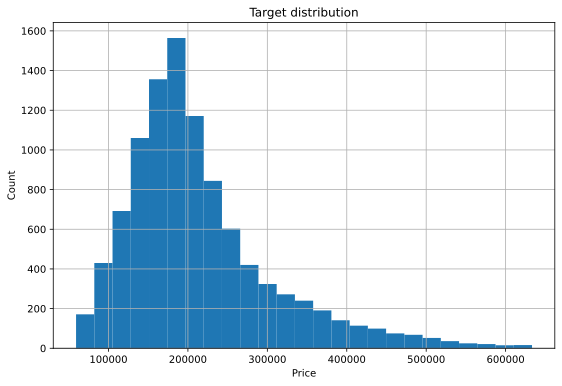

In [8]:
plt.figure(figsize = (9, 6))

df['Price'].hist(bins=25)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Предобработка данных

Видно, что в датасете есть много пропусков и выбросов.

* `Id` 


In [9]:
df['Id'] = df['Id'].astype(str)

*  `Rooms`  

Выбросы заменим на значение, наиболее часто встречающимся для данной площади

In [10]:
df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [11]:
df.loc[(df['Rooms'].between(6.0, 19.0)) | (df['Rooms'] == 0.0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646


In [12]:
df.loc[df['Rooms'] == 19, 'Rooms'] = df['Rooms'].loc[(df['Square'].between(41.9, 42.1))&
                                                     (df['LifeSquare'].between(21.5, 22))].mode()[0]

df.loc[df['Rooms'] == 17, 'Rooms'] = df['Rooms'].loc[(df['Square'].between(52.5, 53.1))&
                                                     (df['LifeSquare'].between(32, 33))].mode()[0]

df.loc[df['Rooms'] == 10, 'Rooms'] = df['Rooms'].loc[(df['Square'].between(58.5, 62))&
                                                     (df['LifeSquare'].between(36, 39))].mode()[0]

df['Rooms'].loc[(df['Rooms'] == 6)&(df['Id'] =='14003')] = df['Rooms'].loc[(df['Square'].between(59, 60))&
                                                                           (df['LifeSquare'].between(38, 39.5))].mode()[0]

df['Rooms'].loc[(df['Rooms'] == 6)&(df['Id'] =='10793')] = df['Rooms'].loc[(df['Square'].between(108, 113))].mode()[0]

df['Rooms'].loc[(df['Rooms'] == 0)&(df['Id'] =='10729')] = df['Rooms'].loc[(df['Square'].between(75, 77))&
                                                                           (df['LifeSquare'].between(40, 55))].mode()[0]

df['Rooms'].loc[(df['Rooms'] == 0)&(df['Id'] =='3159')] = df['Rooms'].loc[(df['Square'].between(37, 40))&
                                                                           (df['LifeSquare'].between(18, 20))].mode()[0]

* `Square`

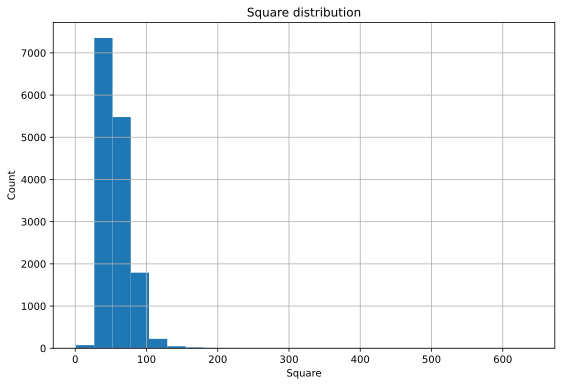

In [13]:
plt.figure(figsize = (9, 6))

df['Square'].hist(bins=25)
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Square distribution')
plt.show()

In [14]:
df.loc[df['Square'] > 400]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


Квартиры, которые больше 400 м2 встречаются всего 3 раза в датасете, мы можем их удалить

In [15]:
df = df.loc[df['Square'] <= 400]

* `Square`

In [16]:
df.loc[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,10262,27,2.0,69.196440,NaN,0.0,10,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,NaN
4887,12116,88,3.0,89.549559,NaN,0.0,20,0.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,NaN
4892,16357,58,1.0,49.205978,NaN,0.0,4,0.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,NaN
4976,4723,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,NaN


заполним нули в HouseValues так, чтобы считалась mode() значений больших, чем этаж

In [17]:
floor = df['Floor'].loc[df['HouseFloor'] == 0]
house_floor = df['HouseFloor'].loc[df['HouseFloor'] == 0]
mode1=[]
for e in floor.values:
    a = df['HouseFloor'].loc[df['HouseFloor'].values >= e].mode()[0]
    mode1.append(a)
for i in range(0, len(mode1)):
    house_floor.values[i] = mode1[i]
    

df['HouseFloor'].loc[df['HouseFloor'] == 0] = house_floor

df.loc[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Проверим, нет ли у нас ситуации, когда этаж квартиры выше высоты дома

In [18]:
df.loc[df['Floor'] > df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,402871.916317
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,148862.210174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,15181,27,4.0,104.664209,66.903563,1.0,4,1.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,NaN
4972,16064,30,1.0,38.376234,37.003311,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN
4989,2591,39,2.0,44.203592,30.191691,6.0,10,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B,NaN
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B,NaN


Предположим, что в тех значениях, где этажность дома ниже, чем этаж, перепутали мастами столбец, попробуем их местами поменять

In [19]:
df['Floor'].loc[df['Floor'] > df['HouseFloor']], \
df['HouseFloor'].loc[df['Floor'] > df['HouseFloor']] =\
df['HouseFloor'].loc[df['Floor'] > df['HouseFloor']], \
df['Floor'].loc[df['Floor'] > df['HouseFloor']]

* `HouseYear`

In [20]:
df['HouseYear'].value_counts()

1977        3949
2016         476
2015         458
2017         449
2014         308
            ... 
1908           1
20052011       1
1947           1
1920           1
4968           1
Name: HouseYear, Length: 105, dtype: int64

In [21]:
df['HouseYear'][df['HouseYear'] == 4968] = 1968
df['HouseYear'][df['HouseYear'] == 20052011] = 2011


* `LifeSuare`

Посмотрим, есть ли такие значения, в которых жилая площадь больше, чем общая

In [22]:
err = df['LifeSquare'] > df['Square']
df.loc[err]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3.0,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20.0,25.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17.0,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,3.0,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,1.0,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,14686,1,3.0,77.229885,79.958685,1.0,17.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
4951,3711,94,1.0,41.281057,42.392594,10.0,13.0,13.0,2014,0.282798,B,B,33,8667,2,NaN,0,6,B,NaN
4962,5820,94,1.0,33.680382,34.198977,1.0,9.0,9.0,1972,0.127376,B,B,43,8429,3,NaN,3,9,B,NaN
4969,4821,74,2.0,82.542507,82.585069,0.0,4.0,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B,NaN


Поменяем местами эти значения

In [23]:
df['Square'].loc[err], df['LifeSquare'].loc[err] =\
df['LifeSquare'].loc[err], df['Square'].loc[err]
df.loc[df['LifeSquare'] > df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


* `Kitchen`

In [24]:
df['KitchenSquare'].sort_values().unique()

array([0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
       6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01,
       1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01,
       2.400e+01, 2.500e+01, 2.600e+01, 2.700e+01, 2.900e+01, 3.000e+01,
       3.100e+01, 3.200e+01, 3.300e+01, 3.400e+01, 3.500e+01, 3.600e+01,
       3.700e+01, 3.900e+01, 4.000e+01, 4.100e+01, 4.200e+01, 4.300e+01,
       4.400e+01, 4.800e+01, 5.100e+01, 5.300e+01, 5.400e+01, 5.700e+01,
       5.800e+01, 6.000e+01, 6.100e+01, 6.200e+01, 6.300e+01, 6.500e+01,
       6.600e+01, 7.200e+01, 7.300e+01, 7.500e+01, 7.800e+01, 8.400e+01,
       9.600e+01, 9.700e+01, 1.120e+02, 1.230e+02, 6.200e+02, 1.970e+03,
       2.014e+03])

In [25]:
df['KitchenSquare'].loc[df['KitchenSquare'] > 50] = df['KitchenSquare'].median()
df['KitchenSquare'].loc[df['KitchenSquare'] <  3] = df['KitchenSquare'].median()
df['KitchenSquare'].loc[(df['Id'] == '10662')] = 3
df['KitchenSquare'].loc[(df['Id'] == '3194')] = 4

* `LifeSquare`

In [26]:
# Заполним нули (проверить второй способ потом)

ls_null = df['LifeSquare'].isnull()
df['LifeSquare'].loc[ls_null] = df['Square'].loc[ls_null] - \
                                df['KitchenSquare'].loc[ls_null]
df.loc[ls_null]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,74.312926,6.0,14.0,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,58.511437,6.0,9.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
21,11935,27,2.0,64.711835,58.711835,6.0,1.0,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54,3.0,118.907612,112.907612,6.0,2.0,17.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
25,5073,74,2.0,82.667915,76.667915,6.0,16.0,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.827069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,39.542940,6.0,6.0,17.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,NaN
4985,11732,1,1.0,46.597283,40.597283,6.0,17.0,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
4987,5361,53,3.0,80.102103,74.102103,6.0,13.0,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,NaN
4998,4780,62,2.0,81.305222,75.305222,6.0,4.0,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,NaN


In [27]:
df['Square'].loc[df['Square'] < 10] = df['Square'].loc[df['Square'] < 10] * 10
df['LifeSquare'].loc[df['LifeSquare'] < 5] = df['Square'].loc[df['LifeSquare'] < 5] - \
                                             df['KitchenSquare'].loc[df['LifeSquare'] < 5]

In [28]:
mask = df["Square"] < df["KitchenSquare"] + df["LifeSquare"]
df['LifeSquare'].loc[mask] = df['Square'].loc[mask] - \
                             df['KitchenSquare'].loc[mask]
df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,44.352981,9.0,8.0,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
14,10953,27,1.0,53.769097,47.769097,6.0,4.0,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
28,8054,23,1.0,43.967759,37.967759,6.0,3.0,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
42,9833,1,2.0,56.494318,50.494318,6.0,9.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,196078.907289
44,10521,38,3.0,106.340403,100.340403,6.0,20.0,25.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,4821,74,2.0,82.585069,76.585069,6.0,4.0,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B,NaN
4972,16064,30,1.0,38.376234,32.376234,6.0,1.0,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN
4974,5296,52,1.0,44.634608,38.634608,6.0,5.0,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,NaN
4979,14090,2,1.0,39.082641,32.082641,7.0,10.0,14.0,1970,0.000000,B,B,33,7425,1,NaN,2,5,B,NaN


In [29]:
df.loc[df['LifeSquare'] < 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


* Healthcare_1

In [30]:
null_health_mask = df['Healthcare_1'].isnull()
notnull_health_mask = df['Healthcare_1'].notnull()
df_health = df.loc[notnull_health_mask]
df_health

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8.0,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,44.352981,9.0,8.0,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5.0,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,2591,39,2.0,44.203592,30.191691,6.0,9.0,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B,NaN
4991,2105,64,2.0,45.493240,32.022565,6.0,4.0,9.0,1974,0.135650,B,B,46,7960,6,350.0,3,11,B,NaN
4993,14562,113,2.0,46.627882,27.058739,5.0,5.0,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B,NaN
4994,6836,39,2.0,45.131282,30.780551,6.0,2.0,5.0,1965,0.428826,B,B,25,5011,8,730.0,0,2,B,NaN


In [31]:
df.loc[null_health_mask, 'Healthcare_1'] = df['Healthcare_1'].median()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             14997 non-null  object 
 1   DistrictId     14997 non-null  int64  
 2   Rooms          14997 non-null  float64
 3   Square         14997 non-null  float64
 4   LifeSquare     14997 non-null  float64
 5   KitchenSquare  14997 non-null  float64
 6   Floor          14997 non-null  float64
 7   HouseFloor     14997 non-null  float64
 8   HouseYear      14997 non-null  int64  
 9   Ecology_1      14997 non-null  float64
 10  Ecology_2      14997 non-null  object 
 11  Ecology_3      14997 non-null  object 
 12  Social_1       14997 non-null  int64  
 13  Social_2       14997 non-null  int64  
 14  Social_3       14997 non-null  int64  
 15  Healthcare_1   14997 non-null  float64
 16  Helthcare_2    14997 non-null  int64  
 17  Shops_1        14997 non-null  int64  
 18  Shops_2

* Обработка категориальных признаков

In [33]:
cat_colnames = df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [34]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    14852
A      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    14573
A      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    13760
A     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



In [35]:
# Новый признак
df['Ecology_Concat23'] = df['Ecology_2'] + df['Ecology_3']

заменим Колонки с A и B на 0 и 1 

In [36]:
for cat_colname in cat_colnames[1:]:
    df[cat_colname][df[cat_colname].values == 'A'] = 0
    df[cat_colname][df[cat_colname].values == 'B'] = 1
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
df['Ecology_2'] = df['Ecology_2'].astype('int64')
df['Ecology_3'] = df['Ecology_3'].astype('int64')
df['Shops_2'] = df['Shops_2'].astype('int64')    

Ecology_2

1    14852
0      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

1    14573
0      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

1    13760
0     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



Новый признак преобразуем в несколько биннарных (One Hot Encoding)


In [37]:
df = pd.concat([df, pd.get_dummies(df['Ecology_Concat23'])], axis=1)
df = df.drop('Ecology_Concat23', axis=1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,AB,BA,BB
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730,0,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,0,0,1
2,4765,53,2.0,44.947953,29.197612,6.0,8.0,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,0,0,1
3,5809,58,2.0,53.352981,44.352981,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,0,0,1


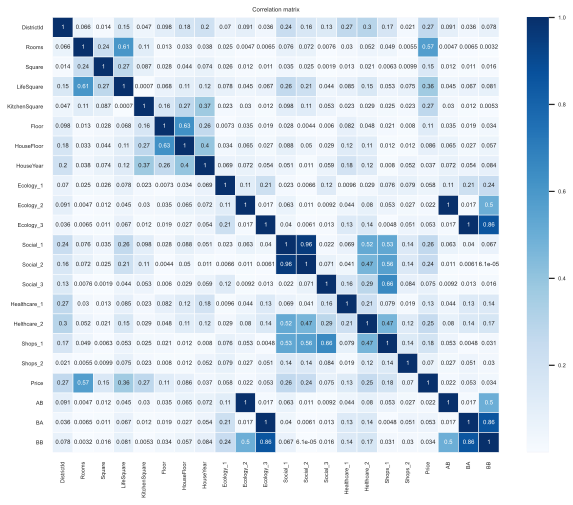

In [38]:
df.corr()
plt.figure(figsize=(10,8))

sns.set(font_scale=0.5)
sns.heatmap(df.corr().abs(), annot=True, linewidth=.5, cmap='Blues')
plt.title('Correlation matrix')
plt.show()

**Построение новых признаков**

In [39]:
gp = df.groupby(["Rooms"])["Square"].mean()
df["Mean_Square_by_rooms"] = df["Rooms"].map(gp.to_dict())

df["diff_square_and_mean_square_by_rooms"] = df["Square"] - df["Mean_Square_by_rooms"]
df["ratio_square_and_mean_square_by_rooms"] = df["Square"] / df["Mean_Square_by_rooms"] - 1

In [40]:
df["bigger_then_mean"] = np.where(
    df["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

In [41]:
district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [42]:
df = df.merge(district_size, on='DistrictId', how='left')

In [43]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)

In [44]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

In [45]:
med_price_by_rooms = df.groupby(['Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByRooms'})

In [46]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df = df.merge(med_price_by_rooms, on=['Rooms'], how='left')

In [47]:
df['MedPriceByDistrict'].loc[df['MedPriceByDistrict'].isnull()] =\
df['MedPriceByRooms'].loc[df['MedPriceByDistrict'].isnull()]

df['MedPriceByDistrict'].loc[df['MedPriceByDistrict'].isnull()] =\
df['MedPriceByRooms'].loc[df['Rooms'] == 4].mode()[0] / 4 * 6 

df['MedPriceByRooms'].loc[df['MedPriceByRooms'].isnull()] =\
df['MedPriceByRooms'].loc[df['Rooms'] == 4].mode()[0] / 4 * 6

In [48]:
df['DistrictId'] = df['DistrictId'].astype(str)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14996
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Id                                     14997 non-null  object 
 1   DistrictId                             14997 non-null  object 
 2   Rooms                                  14997 non-null  float64
 3   Square                                 14997 non-null  float64
 4   LifeSquare                             14997 non-null  float64
 5   KitchenSquare                          14997 non-null  float64
 6   Floor                                  14997 non-null  float64
 7   HouseFloor                             14997 non-null  float64
 8   HouseYear                              14997 non-null  int64  
 9   Ecology_1                              14997 non-null  float64
 10  Ecology_2                              14997 non-null  int64  
 11  Ec

Разбиваем готовый датасет обратно и сохраняем. Далее работаем с train_df

In [50]:
test_df_p = df.loc[df['Price'].isnull()]
train_df_p = df.loc[df['Price'].notnull()]

# Сохраняем обработанный датасет

train_df_p.to_csv('train_df_p.csv', index=False, encoding='utf-8')
test_df_p.to_csv('test_df_p.csv', index=False, encoding='utf-8')

In [51]:
df_train = pd.read_csv('train_df_p.csv')
df_test = pd.read_csv('test_df_p.csv')

In [54]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,AB,BA,BB,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByRooms
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,1,1,11,2748,1,900.0,0,0,1,NaN,0,0,1,56.735589,-6.852946,-0.120787,0,270,1,166809.665642,200377.728472
1,15856,74,2.0,69.263183,63.263183,6.0,1.0,1.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,NaN,0,0,1,56.735589,12.527594,0.220807,1,175,1,243031.695525,200377.728472
2,5480,190,1.0,15.948246,3.948246,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,NaN,0,0,1,41.351880,-25.403633,-0.614328,0,9,0,154983.674298,154983.674298
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,1,1,23,4583,3,900.0,3,3,1,NaN,0,0,1,56.735589,16.311020,0.287492,1,146,1,222227.584211,200377.728472
4,14275,27,1.0,47.527111,41.527111,6.0,17.0,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,NaN,0,0,1,41.351880,6.175231,0.149334,1,1242,1,118327.090620,154983.674298


**Построим модель RandomForestRegressor**

* Сначала на train_fd

In [55]:
df_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'AB', 'BA', 'BB',
       'Mean_Square_by_rooms', 'diff_square_and_mean_square_by_rooms',
       'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean',
       'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict',
       'MedPriceByRooms'],
      dtype='object')

In [56]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
            'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
            'Shops_2']
new_features = ['AB', 'BA', 'BB', 'Mean_Square_by_rooms', 'diff_square_and_mean_square_by_rooms',
                'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean', 'DistrictSize',
                'MedPriceByDistrict', 'MedPriceByRooms']
target = 'Price'

X = df_train[features + new_features]
Y = df_train[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

Train R2:	0.863
Test R2:	0.743


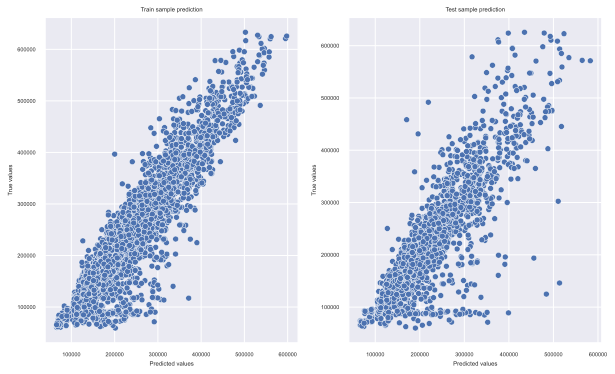

In [57]:
rf_params = RandomForestRegressor(max_depth=9, max_features=11,  
                                  n_estimators=250, random_state=42)
rf_params.fit(X_train, Y_train)
Y_train_preds = rf_params.predict(X_train)
Y_test_preds = rf_params.predict(X_test)

evaluate_preds(Y_train, Y_train_preds, Y_test, Y_test_preds)

* Теперь сделаем предсказания на test_df

In [58]:
Y_train_f = df_train['Price']
X_train_f = df_train.drop('Price', axis=1)
X_test_f = df_test.drop('Price', axis=1)

rf_params = RandomForestRegressor(max_depth=9, max_features=11, n_estimators=250, random_state=42)
rf_params.fit(X_train_f, Y_train_f)

Y_test_f = rf_params.predict(X_test_f)
Id = X_test_f['Id'].values

In [59]:
Y_test = pd.DataFrame({'Id': Id, 'Price':Y_test_f}, columns=['Id','Price'])
Y_test.to_csv('Sokolova_predictions_1.csv', header=True, index=False, encoding='utf-8')

In [60]:
#df['Price'].isnull().sum()